# Finite Difference Methods (An Aside)

Finite-difference methods are perfectly adequate (sometimes excellent) 
methods for many PDEs. They are easy to implement, and can be rigorously 
analyzed just ad finite element methods. This notebook is intended to 
show some simple examples. One difficulty with FD methods is that they become 
much more difficult to use when we go beyond those examples, whereas FEMs 
are often more flexible and can be more easily adapted to complex real-world
scenarios. 

In [113]:
using LinearAlgebra, Plots, SparseArrays

## Example 1: Poisson's Equation on the Unit Square

Let $\Omega = (0, 1)^2$ then we solve
$$
\begin{aligned}
 - \Delta u = - u_{xx} - u_{yy} &= f, \qquad \Omega, \\ 
   u &= 0, \qquad \partial\Omega
\end{aligned}
$$
via a 5-point centered finite difference scheme: We take $N+1$ grid points in each coordinate direction ... 


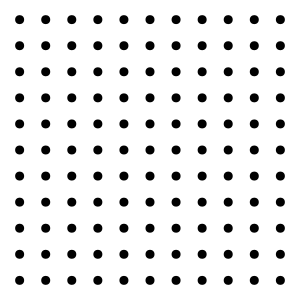

In [109]:
N = 10; x = range(0, 1, N+1); o = ones(N+1); 
scatter((x*o')[:], (o*x')[:], c=:black, ms=5, aspect_ratio=:equal, legend=false, 
        grid=false, ticks=false, border=:none, size = (300, 300))

... let $h = 1/N$, we think of the grid function $U_{nm} \approx u(hn, hm)$$ and then determine $U$ by solving the linear system 
$$
\begin{aligned}
  - \frac{U_{n+1,m}+U_{n-1,m}+U_{n,m+1}+U_{n,m-1} - 4 U_{nm}}{h^2} &= F_{nm}, \qquad n, m = 1, \dots, N-1, \\ 
  U_{nm} &= 0, \qquad n = 0, N \text{ or } m = 0, N.
\end{aligned}
$$
and where $F_{nm} = f(hn, hm)$. Here, we can observe a key difference between FD and FE methods. FD methods are specified in terms of functions on grids - i.e. the solution is only defined on grid points. By contrast, FE methods start by defining approximation spaces of continuous functions i.e. functions that are themselves trial functions for the equation under consideration. 

In [110]:
# This is a very naive but short implementation of the 5-point FD 
# (neg.) laplacian on an equispaced grid with N+1 gridpoints in each coord.
L1d(N) = sparse(Tridiagonal(-N^2 * ones(N-2), 2*N^2*ones(N-1), -N^2*ones(N-2)))
Id(N) = sparse(I, (N-1,N-1))
L2d(N) = sparse(kron(L1d(N), Id(N)) + kron(Id(N), L1d(N)));

In [111]:
# solve `- Δu = 1`` on the unit square with homogeneous Dirichlet b.c.
N = 20
F = ones((N-1)^2)
L = L2d(N)
U = L \ F;   # solution at interior gridpoints

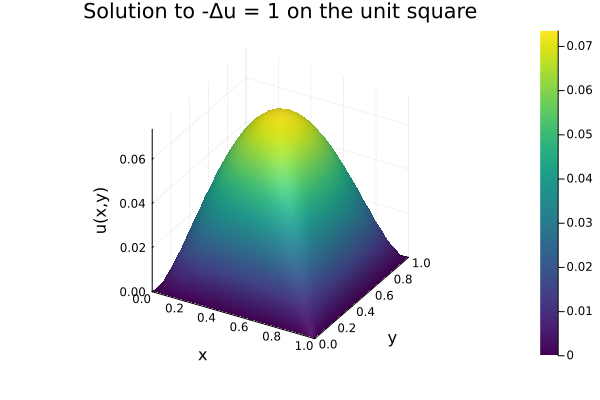

In [114]:
# postprocess: add the boundary condition, then plot
U0 = zeros(N+1, N+1)
U0[2:end-1, 2:end-1] = reshape(U, N-1, N-1)
x = y = range(0, 1, length=N+1)
surface(x, y, U0, xlabel="x", ylabel="y", zlabel="u(x,y)", 
        title="Solution to -Δu = 1 on the unit square", 
        c = :viridis)


## Finite Difference Method on a More Complex Domain



In [115]:
function lshape(N)
   @assert iseven(N) 
   # the domain is defined by coloring the grid points. Start will all false.  
   Ω = fill(false, (N+2, N+2))
   # fill in the "domain" with true
   n0 = 2; n1 = N÷2+1; n2 = n1+1; n3 = N+1 
   Ω[n0:n3,n0:n3] .= true; Ω[n0:n1,n2:n3] .= false
   return Ω
end

# generate a mesh for demonstration
Ω = lshape(8)

10×10 Matrix{Bool}:
 0  0  0  0  0  0  0  0  0  0
 0  1  1  1  1  0  0  0  0  0
 0  1  1  1  1  0  0  0  0  0
 0  1  1  1  1  0  0  0  0  0
 0  1  1  1  1  0  0  0  0  0
 0  1  1  1  1  1  1  1  1  0
 0  1  1  1  1  1  1  1  1  0
 0  1  1  1  1  1  1  1  1  0
 0  1  1  1  1  1  1  1  1  0
 0  0  0  0  0  0  0  0  0  0

In [116]:
function fdlaplacian(Ω) 
   # construct the laplacian on the extended grid (square)
   M, N = size(Ω)
   Δ = kron(Id(M+1), L1d(N+1)) + kron(L1d(M+1), Id(N+1))
   # return the restriction to the coloured grid points
   nonz = findall(isequal(true), Ω[:])
   return sparse(Δ[nonz, nonz]), nonz
end

L, _ = fdlaplacian(lshape(8))
L


48×48 SparseMatrixCSC{Float64, Int64} with 208 stored entries:
⎡⠻⣦⡀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠈⠻⣦⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠑⢄⠀⠀⠻⣦⡀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠑⢄⠀⠈⠻⣦⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠑⢄⠀⠀⠻⣦⡀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠑⢄⠀⠈⠻⣦⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠈⠻⣦⠑⢄⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠻⣦⠑⢄⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠻⣦⠑⢄⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠻⣦⠑⢄⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠻⣦⎦

In [117]:
# solve the finite different problem 
# again we are solving only for the interior grid points (DoFs)
N = 30
L, nonz = fdlaplacian(lshape(N))
U = L \ ones(size(L, 1));  

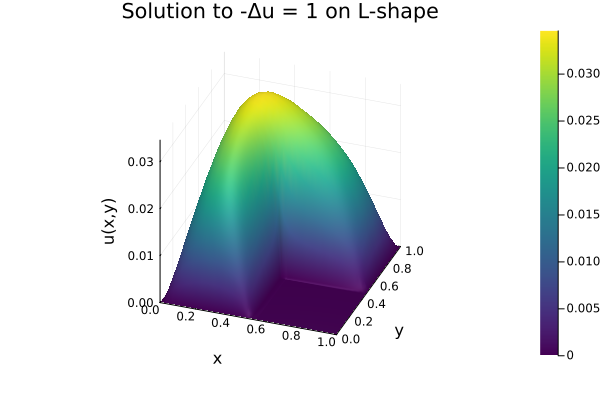

In [122]:
# post process by writing the interior nodes into a larger 
# grid function 
U0 = zeros(N+2, N+2)
U0[nonz] .= U
x = y = range(0, 1, length=N+2)
surface(x, y, U0, xlabel="x", ylabel="y", zlabel="u(x,y)", 
         title="Solution to -Δu = 1 on L-shape",
         camera=(20, 30), c=:viridis,)


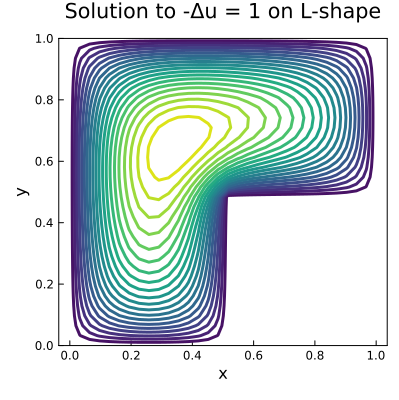

In [132]:
# And maybe while we are plotting, also a nice contour plot? 

contour(x, y, U0, xlabel="x", ylabel="y", zlabel="u(x,y)", 
         title="Solution to -Δu = 1 on L-shape", lw = 3, 
         c = :viridis, levels = 20, colorbar = false, 
         aspect_ratio=:equal, grid=false, border=:box, 
         xticks = 0.0:0.2:1.0, yticks = 0.0:0.2:1.0, size = (400, 400))

### Final remarks

Clearly we can generalize the above implementation in a few ways, but even for slightly more complex geometries the approach introduced large errors. For example if the angle in the "hole" is not 90 degrees, but - say - 78 deg, then the boundary is no longer exactly represented which introduces potentially large solution errors. One can then use coordinate transformations to a simpler domain. This makes the implementation quite a bit more complex. And for much more complex domains such simple techniques can no longer be applied at all. This is one of the scenarios (but not the only one) where finite element methods have a significant advantage. 
